In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils import *
support_chinese()


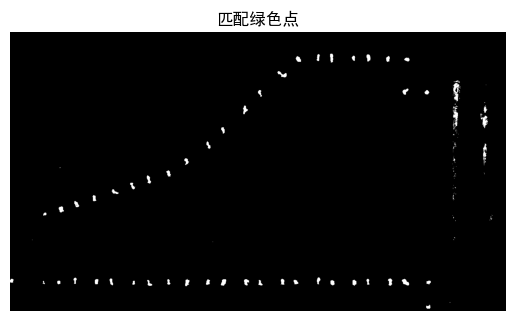

In [19]:
# 读取图像
image = cv2.imread('./saveImg/raw.jpg')

# 将图像转换为HSV颜色空间
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# 定义绿色的HSV范围
lower_green = np.array([35, 100, 100])
upper_green = np.array([85, 255, 255])

# 根据阈值创建掩膜
mask = cv2.inRange(hsv, lower_green, upper_green)
height, width = mask.shape

# 寻找连通块
connectivity = 4  # 或8，具体根据你的需求来确定
output = cv2.connectedComponentsWithStats(mask, connectivity, cv2.CV_32S)

imshow(mask, title="匹配绿色点")


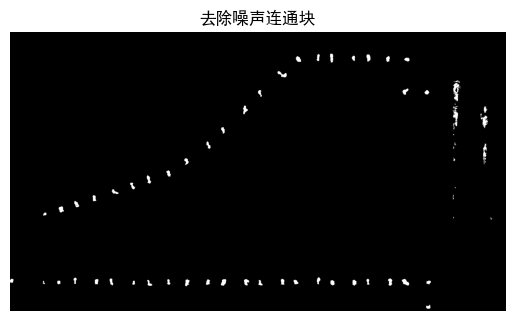

In [20]:
# 获取连通块属性
num_labels = output[0]
labels = output[1]
stats = output[2]
centroids = output[3]

# print(stats[:, -1])

threshold = 5

for label in range(1, output[0]):
    if stats[label, cv2.CC_STAT_AREA] < threshold:  
        # 如果连通块的像素点数小于阈值，则将对应像素赋值为 0
        labels[labels == label] = 0
new_mask = np.where(labels > 0, 255, labels).astype(np.uint8)

imshow(new_mask, title="去除噪声连通块")


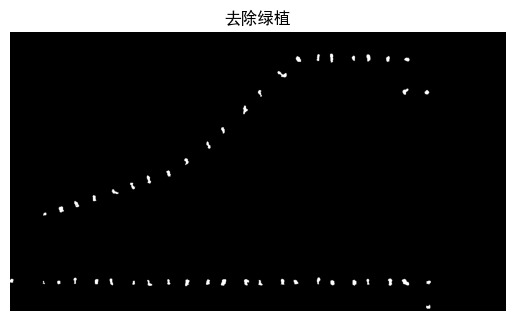

In [21]:
List = []
th_right = 1100

# 去除图片中右边的绿植
for y in range(height):
    for x in range(width):
        if x > th_right:
            new_mask[y, x] = 0  # 将对应位置的像素标签设为 0，即赋值为黑色

imshow(new_mask, title="去除绿植")

In [22]:
# 重新获得上图的连通块
new_output = cv2.connectedComponentsWithStats(new_mask, connectivity, cv2.CV_32S)
print(len(new_output[3]))

48


In [23]:
new_output[3][:, 1].max()

709.3086419753087

In [24]:
# 写入json文件
import json
with open('./config/settings.json', 'r') as f:
    data = json.load(f)
with open('./config/data_road.json', 'w') as f:
    data['cnt'] = len(new_output[3])

    res = [{"x": x, "y": y, "is_entrance": 0, "is_empty": 0, "id" : None, 
                "is_parking": 0, "direction": 0} 
        for x, y in new_output[3]]
    # 特判两个入口
    # 一个入口靠最左边，一个靠最下边
    # x < 4.66 or y > 708
    for dict in res :
        if dict['x'] < 4.66 or dict['y'] > 708:
            dict['is_entrance'] = 1

    json.dump(res, f, indent=4)
with open('./config/settings.json', 'w') as f:
    json.dump(data, f, indent=4)